# Z-Score

## 1. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Carga de Datos

In [ ]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
rul = pd.read_csv('../data/rul.csv')

print(f"Train: {train.shape}, Test: {test.shape}, RUL: {rul.shape}")

Train: (20631, 18), Test: (13096, 17), RUL: (100, 1)


## 3. Definición de Features

In [ ]:
feature_cols = [
    'setting_1', 'setting_2', 'setting_3',
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 
    'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 
    'sensor_14', 'sensor_15', 'sensor_17', 'sensor_21'
]

print(f"Features seleccionados: {len(feature_cols)}")
print(feature_cols)

Features seleccionados: 15
['setting_1', 'setting_2', 'setting_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_21']


## 4. Verificar Estructura de Datos

In [ ]:
print("Columnas en train:")
print(train.columns.tolist())
print(f"\nPrimeras filas de train:")
display(train.head(10))

required_cols = ['unit_id', 'time_cycles', 'RUL']
missing_cols = [col for col in required_cols if col not in train.columns]

print(f"\nEstadísticas de RUL:")
print(train['RUL'].describe())

Columnas en train:
['unit_id', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_21', 'RUL']

Primeras filas de train:


,unit_id,time_cycles,setting_1,setting_2,setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.194427,191
1,1,2,0.0019,-0.0003,100.0,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.236922,190
2,1,3,-0.0043,0.0003,100.0,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.503423,189
3,1,4,0.0007,0.0000,100.0,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.777792,188
4,1,5,-0.0019,-0.0002,100.0,-0.621816,-1.251528,-0.301518,0.714393,-0.516338,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,1.059552,187
5,1,6,-0.0043,-0.0001,100.0,-1.161771,-0.987297,-1.173703,1.471395,-1.079848,-1.427163,0.361379,-0.919841,-0.571550,-0.835790,-1.427402,0.713126,186
6,1,7,0.0010,0.0001,100.0,-0.401834,0.293081,-1.240367,1.098544,-1.079848,-0.678327,1.229134,-0.919841,-0.599334,-1.193084,-0.781710,0.810125,185
7,1,8,-0.0034,0.0003,100.0,-0.241847,-1.233586,-0.884827,0.544915,-1.361602,-1.127629,1.432514,-0.919841,-0.664862,-0.921114,-1.427402,0.193025,184
8,1,9,0.0008,0.0001,100.0,-1.121775,0.074520,-1.570353,0.364139,-0.657216,-0.940420,0.510525,-0.641744,-0.946896,-1.849012,-0.781710,1.079876,183
9,1,10,-0.0033,0.0001,100.0,-1.941707,0.116927,-0.941491,0.251154,-0.657216,-1.913907,0.510525,-0.502695,-0.753457,-0.361176,-0.136018,1.660023,182



Estadísticas de RUL:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64


## 5. Función para Calcular Z-Scores

In [ ]:
def calculate_z_scores(data, features, baseline_percentile=0.2):
    """
    Calcula Z-scores usando estadísticas de la fase normal (baseline).
    
    Parameters:
    -----------
    data : DataFrame con columnas 'unit_id', 'time_cycles', 'RUL' y features
    features : lista de nombres de columnas de features
    baseline_percentile : fracción inicial de ciclos considerados "normales"
    
    Returns:
    --------
    DataFrame con Z-scores para cada feature
    """
    z_scores_list = []
    
    for unit_id in data['unit_id'].unique():
        unit_data = data[data['unit_id'] == unit_id].copy()
        
        # Definir "baseline" como el percentil inicial de ciclos (operación normal)
        max_cycle = unit_data['time_cycles'].max()
        baseline_threshold = int(max_cycle * baseline_percentile)
        baseline_data = unit_data[unit_data['time_cycles'] <= baseline_threshold]
        
        # Calcular media y std de la fase normal
        baseline_mean = baseline_data[features].mean()
        baseline_std = baseline_data[features].std()
        
        # Evitar división por cero
        baseline_std = baseline_std.replace(0, 1e-6)
        
        # Calcular Z-scores para toda la unidad
        unit_z_scores = (unit_data[features] - baseline_mean) / baseline_std
        unit_z_scores['unit_id'] = unit_id
        unit_z_scores['time_cycles'] = unit_data['time_cycles'].values
        unit_z_scores['RUL'] = unit_data['RUL'].values
        
        z_scores_list.append(unit_z_scores)
    
    return pd.concat(z_scores_list, ignore_index=True)

## 6. Calcular Z-Scores

In [ ]:
print("Calculando Z-scores...")
train_z_scores = calculate_z_scores(train, feature_cols, baseline_percentile=0.2)

print(f"\nZ-scores calculados: {train_z_scores.shape}")
print(f"\nPrimeras filas:")
display(train_z_scores.head(10))

print(f"\nEstadísticas de Z-scores:")
display(train_z_scores[feature_cols].describe())

Calculando Z-scores...

Z-scores calculados: (20631, 18)

Primeras filas:


,setting_1,setting_2,setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_21,unit_id,time_cycles,RUL
0,-0.085981,-1.444145,0.0,-1.587337,0.595988,0.115566,0.427697,0.016382,1.642065,-1.129007,-1.004691,1.572467,0.357533,0.089541,0.518343,1,1,191
1,1.145166,-1.075839,0.0,-0.550067,1.096173,1.010066,-1.133567,-0.606146,1.824250,0.639570,0.715050,-0.268692,1.001009,0.089541,0.600414,1,2,190
2,-1.790645,1.133993,0.0,0.078581,0.192537,1.383361,0.171753,0.638911,-0.179788,1.038927,-0.660743,0.180623,0.268597,-2.178822,-0.816202,1,3,189
3,0.576944,0.029077,0.0,0.078581,-1.034333,0.562816,0.658048,1.572703,-1.455085,2.294046,1.058998,0.335559,-2.326235,0.089541,-0.286309,1,4,188
4,-0.654202,-0.707534,0.0,0.141446,-1.020177,2.094736,-0.493704,0.016382,-0.088695,0.382841,-0.316794,0.327812,0.875453,1.223722,0.257857,1,5,187
5,-1.790645,-0.339229,0.0,-0.707230,-0.637960,-0.669763,1.221127,-1.228674,-1.181807,-1.071956,-0.660743,0.082497,-0.097609,-1.044641,-0.411200,1,6,186
6,0.719000,0.397382,0.0,0.487203,1.214142,-0.881062,0.376508,-1.228674,0.640046,0.753672,-0.660743,-0.054364,-0.798632,0.089541,-0.223864,1,7,185
7,-1.364479,1.133993,0.0,0.738662,-0.994224,0.245867,-0.877622,-1.851202,-0.453066,1.181554,-0.660743,-0.377147,-0.265018,-1.044641,-1.415677,1,8,184
8,0.624296,0.397382,0.0,-0.644365,0.897987,-1.926994,-1.287134,-0.294882,0.002397,-0.758176,0.027154,-1.766409,-2.085585,0.089541,0.297108,1,9,183
9,-1.317127,0.397382,0.0,-1.933094,0.959330,0.066263,-1.543079,-0.294882,-2.366012,-0.758176,0.371102,-0.813551,0.833601,1.223722,1.417555,1,10,182



Estadísticas de Z-scores:


,setting_1,setting_2,setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_21
count,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,-0.015354,0.004069,0.0,1.025621,0.937951,1.614392,-1.476278,1.287228,1.917509,-1.690317,1.372206,2.000808,1.236815,1.047085,-1.191366
std,1.043715,1.010751,0.0,1.606864,1.508857,2.154851,2.045125,2.033064,2.500130,2.273647,2.134085,5.590632,1.794082,1.624966,1.707079
min,-4.716742,-2.553978,0.0,-3.526076,-3.312181,-4.233835,-11.938219,-3.817757,-3.440676,-14.025063,-3.585021,-11.616423,-3.956908,-3.696846,-9.813726
25%,-0.699885,-0.871488,0.0,-0.087517,-0.098290,0.115476,-2.494586,-0.075409,0.181730,-2.782722,-0.045460,-0.586027,-0.018766,-0.032828,-2.131148
50%,-0.004054,-0.009848,0.0,0.813376,0.770403,1.157911,-1.051785,0.860824,1.293283,-1.163417,0.897022,0.510761,0.936874,0.822917,-0.925740
75%,0.685160,0.849117,0.0,1.924482,1.799621,2.702350,-0.074236,2.153751,3.089013,-0.106867,2.313734,2.192876,2.209188,1.928759,0.007069
max,4.247773,2.413664,0.0,8.843909,9.297596,11.460520,3.862703,20.304355,14.891920,4.189891,18.512550,46.131412,9.490406,9.755500,3.131104


## 7. Función para Detectar Anomalías

In [ ]:
def detect_anomalies_z_score(z_scores_df, features, threshold=4.0):
    """
    Detecta anomalías cuando |Z-score| > threshold.
    
    Parameters:
    -----------
    z_scores_df : DataFrame con Z-scores
    features : lista de features
    threshold : umbral de detección (típicamente 2.5 o 3.0)
    
    Returns:
    --------
    DataFrame con flags de anomalía y score agregado
    """
    result = z_scores_df.copy()
    
    # Calcular anomalías por feature (|z| > threshold)
    for feature in features:
        result[f'{feature}_anomaly'] = (np.abs(result[feature]) > threshold).astype(int)
    
    # Score agregado: máximo Z-score absoluto
    result['max_z_score'] = result[features].abs().max(axis=1)
    
    # Anomalía global: si algún feature es anómalo
    anomaly_cols = [f'{f}_anomaly' for f in features]
    result['is_anomaly'] = result[anomaly_cols].max(axis=1)
    
    # Número de features anómalos
    result['n_anomalous_features'] = result[anomaly_cols].sum(axis=1)
    
    return result

## 8. Detectar Anomalías

In [ ]:
# Detectar anomalías con threshold=3.0
threshold = 4.0
print(f"Detectando anomalías con threshold={threshold}...")
train_anomalies = detect_anomalies_z_score(train_z_scores, feature_cols, threshold=threshold)

print(f"\n{'='*60}")
print(f"DETECCIÓN DE ANOMALÍAS - Threshold={threshold}")
print(f"{'='*60}")
print(f"Total de observaciones: {len(train_anomalies):,}")
print(f"Anomalías detectadas: {train_anomalies['is_anomaly'].sum():,}")
print(f"Porcentaje de anomalías: {train_anomalies['is_anomaly'].mean()*100:.2f}%")
print(f"\nDistribución de features anómalos simultáneos:")
print(train_anomalies['n_anomalous_features'].value_counts().sort_index())

Detectando anomalías con threshold=3.0...

DETECCIÓN DE ANOMALÍAS - Threshold=3.0
Total de observaciones: 20,631
Anomalías detectadas: 9,381
Porcentaje de anomalías: 45.47%

Distribución de features anómalos simultáneos:
n_anomalous_features
0     11250
1      2687
2      1216
3       792
4       593
5       552
6       506
7       478
8       540
9       530
10      535
11      510
12      434
13        8
Name: count, dtype: int64


## 9. Análisis de Primera Detección por Unidad

In [ ]:
def analyze_first_detection(anomalies_df):
    """
    Analiza en qué momento se detecta la primera anomalía por unidad.
    """
    results = []
    
    for unit_id in anomalies_df['unit_id'].unique():
        unit_data = anomalies_df[anomalies_df['unit_id'] == unit_id]
        
        # Encontrar primera anomalía
        first_anomaly = unit_data[unit_data['is_anomaly'] == 1]
        
        if len(first_anomaly) > 0:
            first_cycle = first_anomaly['time_cycles'].min()
            first_rul = first_anomaly['RUL'].max()
            total_cycles = unit_data['time_cycles'].max()
            
            results.append({
                'unit_id': unit_id,
                'first_anomaly_cycle': first_cycle,
                'first_anomaly_rul': first_rul,
                'total_cycles': total_cycles,
                'detection_percentage': (first_cycle / total_cycles) * 100
            })
        else:
            results.append({
                'unit_id': unit_id,
                'first_anomaly_cycle': np.nan,
                'first_anomaly_rul': np.nan,
                'total_cycles': unit_data['time_cycles'].max(),
                'detection_percentage': np.nan
            })
    
    return pd.DataFrame(results)

# Análisis de primera detección
print("Analizando primera detección por unidad...")
detection_analysis = analyze_first_detection(train_anomalies)

print(f"\n{'='*60}")
print("ANÁLISIS DE DETECCIÓN TEMPRANA")
print(f"{'='*60}")
print(f"Unidades totales: {len(detection_analysis)}")
print(f"Unidades con anomalías detectadas: {detection_analysis['first_anomaly_cycle'].notna().sum()}")
print(f"Unidades sin detección: {detection_analysis['first_anomaly_cycle'].isna().sum()}")
print(f"\nEstadísticas de RUL en primera detección:")
print(detection_analysis['first_anomaly_rul'].describe())
print(f"\nEstadísticas de % del ciclo de vida en primera detección:")
print(detection_analysis['detection_percentage'].describe())

Analizando primera detección por unidad...

ANÁLISIS DE DETECCIÓN TEMPRANA
Unidades totales: 100
Unidades con anomalías detectadas: 100
Unidades sin detección: 0

Estadísticas de RUL en primera detección:
count    100.000000
mean     172.940000
std       47.211499
min       77.000000
25%      143.500000
50%      166.500000
75%      197.500000
max      334.000000
Name: first_anomaly_rul, dtype: float64

Estadísticas de % del ciclo de vida en primera detección:
count    100.000000
mean      16.464335
std       10.628417
min        0.469484
25%        7.481917
50%       15.627750
75%       24.117021
max       43.795620
Name: detection_percentage, dtype: float64


## 10. Visualización: Evolución Temporal

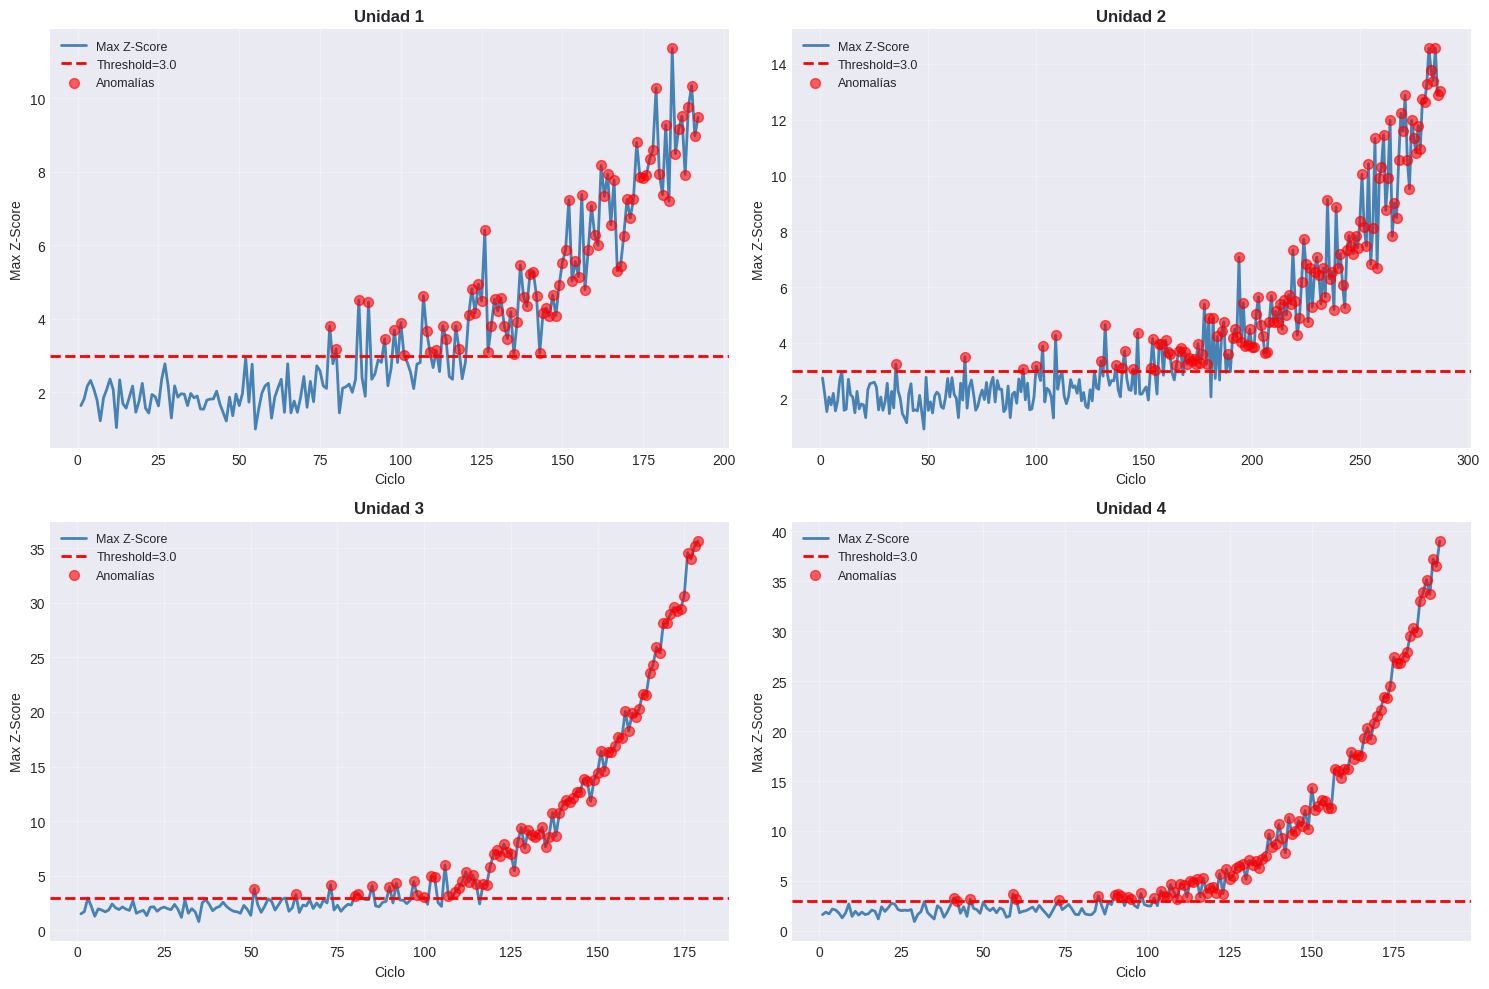

In [ ]:
# Visualizar evolución de anomalías para 4 unidades ejemplo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

sample_units = train_anomalies['unit_id'].unique()[:4]

for idx, unit_id in enumerate(sample_units):
    unit_data = train_anomalies[train_anomalies['unit_id'] == unit_id]
    
    ax = axes[idx]
    ax.plot(unit_data['time_cycles'], unit_data['max_z_score'], 
            label='Max Z-Score', linewidth=2, color='steelblue')
    ax.axhline(y=threshold, color='r', linestyle='--', 
               label=f'Threshold={threshold}', linewidth=2)
    
    # Marcar anomalías
    anomalies = unit_data[unit_data['is_anomaly'] == 1]
    if len(anomalies) > 0:
        ax.scatter(anomalies['time_cycles'], anomalies['max_z_score'], 
                  color='red', s=50, alpha=0.6, label='Anomalías', zorder=5)
    
    ax.set_xlabel('Ciclo', fontsize=10)
    ax.set_ylabel('Max Z-Score', fontsize=10)
    ax.set_title(f'Unidad {unit_id}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/z_score_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Visualización: Features Más Anómalos

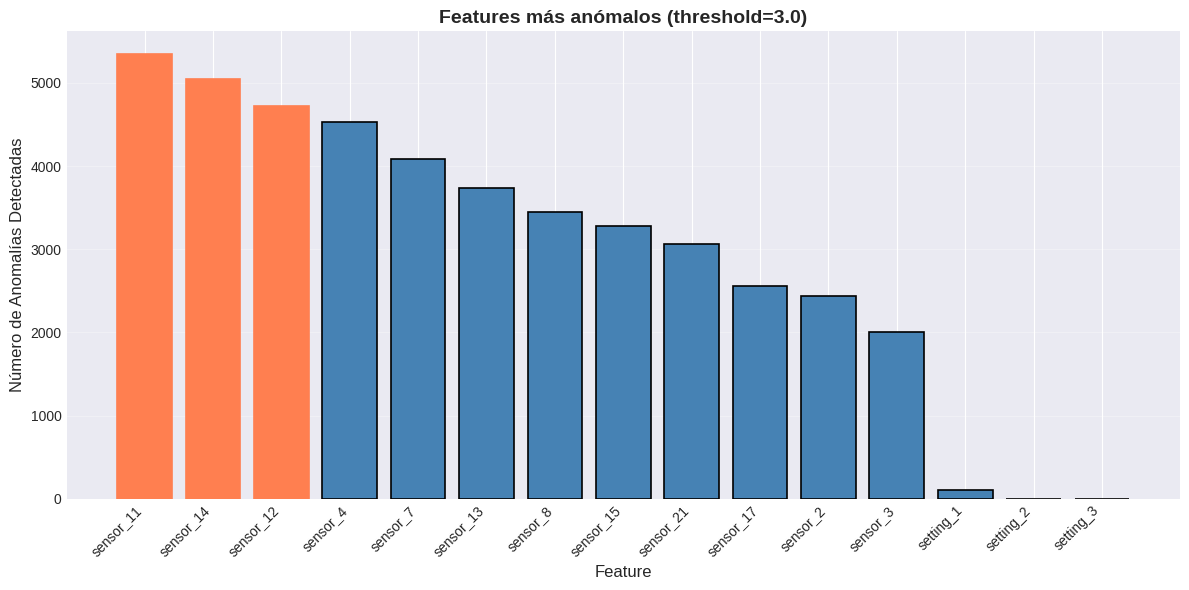


🏆 Top 5 features más anómalos:
  1. sensor_11: 5,352 anomalías
  2. sensor_14: 5,048 anomalías
  3. sensor_12: 4,721 anomalías
  4. sensor_4: 4,532 anomalías
  5. sensor_7: 4,086 anomalías


In [ ]:
# Identificar qué features son más anómalos
anomaly_cols = [f'{f}_anomaly' for f in feature_cols]
feature_anomaly_counts = train_anomalies[anomaly_cols].sum()
feature_anomaly_counts.index = feature_cols
feature_anomaly_counts = feature_anomaly_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(feature_anomaly_counts)), feature_anomaly_counts.values, 
               color='steelblue', edgecolor='black', linewidth=1.2)
plt.xticks(range(len(feature_anomaly_counts)), feature_anomaly_counts.index, 
           rotation=45, ha='right')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Número de Anomalías Detectadas', fontsize=12)
plt.title(f'Features más anómalos (threshold={threshold})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Colorear top 3
for i in range(min(3, len(bars))):
    bars[i].set_color('coral')

plt.tight_layout()
plt.savefig('./outputs/z_score_features_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🏆 Top 5 features más anómalos:")
for i, (feature, count) in enumerate(feature_anomaly_counts.head().items(), 1):
    print(f"  {i}. {feature}: {count:,} anomalías")

## 12. Métricas de Evaluación

In [ ]:
def calculate_detection_metrics(anomalies_df, rul_threshold=50):
    """
    Calcula métricas de detección temprana.
    
    Parameters:
    -----------
    rul_threshold : RUL por debajo del cual se considera que hay degradación
    """
    metrics = {
        'total_units': anomalies_df['unit_id'].nunique(),
        'units_with_anomalies': 0,
        'early_detections': 0,  
        'late_detections': 0,   
        'no_detections': 0,
        'avg_first_rul': [],
        'avg_detection_percentage': []
    }
    
    for unit_id in anomalies_df['unit_id'].unique():
        unit_data = anomalies_df[anomalies_df['unit_id'] == unit_id]
        first_anomaly = unit_data[unit_data['is_anomaly'] == 1]
        
        if len(first_anomaly) > 0:
            metrics['units_with_anomalies'] += 1
            first_rul = first_anomaly['RUL'].max()
            metrics['avg_first_rul'].append(first_rul)
            
            total_cycles = unit_data['time_cycles'].max()
            first_cycle = first_anomaly['time_cycles'].min()
            detection_pct = (first_cycle / total_cycles) * 100
            metrics['avg_detection_percentage'].append(detection_pct)
            
            if first_rul > rul_threshold:
                metrics['early_detections'] += 1
            else:
                metrics['late_detections'] += 1
        else:
            metrics['no_detections'] += 1
    
    # Promedios
    metrics['avg_first_rul'] = np.mean(metrics['avg_first_rul']) if metrics['avg_first_rul'] else 0
    metrics['avg_detection_percentage'] = np.mean(metrics['avg_detection_percentage']) if metrics['avg_detection_percentage'] else 0
    
    return metrics

# Calcular métricas
metrics = calculate_detection_metrics(train_anomalies, rul_threshold=50)

print("="*60)
print("MÉTRICAS DE DETECCIÓN - Z-SCORE")
print("="*60)
print(f"Threshold: {threshold}")
print(f"\nTotal de unidades: {metrics['total_units']}")
print(f"Unidades con anomalías detectadas: {metrics['units_with_anomalies']}")
print(f"Unidades sin detección: {metrics['no_detections']}")
print(f"\nDetecciones tempranas (RUL>50): {metrics['early_detections']}")
print(f"Detecciones tardías (RUL≤50): {metrics['late_detections']}")
print(f"\nRUL promedio en primera detección: {metrics['avg_first_rul']:.2f} ciclos")
print(f"Detección en promedio al {metrics['avg_detection_percentage']:.1f}% del ciclo de vida")
print("="*60)

MÉTRICAS DE DETECCIÓN - Z-SCORE
Threshold: 3.0

Total de unidades: 100
Unidades con anomalías detectadas: 100
Unidades sin detección: 0

Detecciones tempranas (RUL>50): 100
Detecciones tardías (RUL≤50): 0

RUL promedio en primera detección: 172.94 ciclos
Detección en promedio al 16.5% del ciclo de vida


## 13. Guardar Resultados

In [ ]:
# Guardar resultados
train_anomalies.to_csv('./data/train_z_score_anomalies.csv', index=False)
detection_analysis.to_csv('./data/z_score_detection_analysis.csv', index=False)

# Guardar métricas en un archivo
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('./data/z_score_metrics.csv', index=False)

print("✅ Resultados guardados:")
print("   - train_z_score_anomalies.csv")
print("   - z_score_detection_analysis.csv")
print("   - z_score_metrics.csv")

✅ Resultados guardados:
   - train_z_score_anomalies.csv
   - z_score_detection_analysis.csv
   - z_score_metrics.csv


## 14. Resumen y Conclusiones

In [ ]:
# Resumen final
print("="*70)
print("RESUMEN - DETECCIÓN DE ANOMALÍAS CON Z-SCORE")
print("="*70)
print(f"\n📊 DATOS:")
print(f"   • Features analizados: {len(feature_cols)}")
print(f"   • Unidades de entrenamiento: {train['unit_id'].nunique()}")
print(f"   • Total de observaciones: {len(train_anomalies):,}")

print(f"\n🎯 CONFIGURACIÓN:")
print(f"   • Threshold Z-Score: {threshold}")
print(f"   • Baseline: primeros 20% de ciclos")

print(f"\n🔍 RESULTADOS:")
print(f"   • Anomalías detectadas: {train_anomalies['is_anomaly'].sum():,} ({train_anomalies['is_anomaly'].mean()*100:.2f}%)")
print(f"   • Cobertura: {metrics['units_with_anomalies']}/{metrics['total_units']} unidades")
print(f"   • Detección temprana: {metrics['early_detections']} unidades")
print(f"   • RUL medio en 1ª detección: {metrics['avg_first_rul']:.1f} ciclos")

print(f"\n⚠️ FEATURES MÁS CRÍTICOS:")
for i, (feature, count) in enumerate(feature_anomaly_counts.head(5).items(), 1):
    print(f"   {i}. {feature}: {count:,} anomalías")

print(f"\n💡 INTERPRETACIÓN:")
if metrics['avg_first_rul'] > 75:
    print("   ✅ Detección MUY TEMPRANA - Excelente para mantenimiento predictivo")
elif metrics['avg_first_rul'] > 50:
    print("   ✅ Detección TEMPRANA - Buena capacidad predictiva")
elif metrics['avg_first_rul'] > 25:
    print("   ⚠️  Detección MODERADA - Tiempo limitado para intervención")
else:
    print("   ❌ Detección TARDÍA - Poco margen para mantenimiento preventivo")

print(f"\n📈 TASA DE COBERTURA: {(metrics['units_with_anomalies']/metrics['total_units'])*100:.1f}%")
print("="*70)

RESUMEN - DETECCIÓN DE ANOMALÍAS CON Z-SCORE

📊 DATOS:
   • Features analizados: 15
   • Unidades de entrenamiento: 100
   • Total de observaciones: 20,631

🎯 CONFIGURACIÓN:
   • Threshold Z-Score: 3.0
   • Baseline: primeros 20% de ciclos

🔍 RESULTADOS:
   • Anomalías detectadas: 9,381 (45.47%)
   • Cobertura: 100/100 unidades
   • Detección temprana: 100 unidades
   • RUL medio en 1ª detección: 172.9 ciclos

⚠️ FEATURES MÁS CRÍTICOS:
   1. sensor_11: 5,352 anomalías
   2. sensor_14: 5,048 anomalías
   3. sensor_12: 4,721 anomalías
   4. sensor_4: 4,532 anomalías
   5. sensor_7: 4,086 anomalías

💡 INTERPRETACIÓN:
   ✅ Detección MUY TEMPRANA - Excelente para mantenimiento predictivo

📈 TASA DE COBERTURA: 100.0%
